# C_a_1 : Création des features

- [ ] Création des features sur la date (jour, mois, saison, etc.)
- [ ] Création des features sur la température (lag, window, delta, etc.)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import locale
import calendar
from references import *

import warnings

# warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")
pd.options.mode.chained_assignment = None

locale.setlocale(locale.LC_ALL, "fr_CA.UTF-8")

'fr_CA.UTF-8'

In [2]:
%load_ext jupyter_black

# import black
# import jupyter_black

# jupyter_black.load(
#     lab=True,
#     line_length=55,
#     target_version=black.TargetVersion.PY311,
# )

## Import des données

In [3]:
path_to_interim_data = "../data/interim/"
demande_meteo_parquet = "demande_meteo.parquet"

df_import = pd.read_parquet(
    path=os.path.join(path_to_interim_data, demande_meteo_parquet),
    engine="pyarrow",
)
df = df_import["20190101":"20221231"]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35068 entries, 2019-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MW      35018 non-null  float64
 1   Temp    35068 non-null  float64
dtypes: float64(2)
memory usage: 821.9 KB


## Features sur les dates

In [4]:
def create_date_features(df):
    """
    Création des features concernant les dates
    """
    df = df.copy()
    df["date"] = df.index
    df["hourofday"] = df["date"].dt.hour
    df["dayofweek"] = df["date"].dt.dayofweek
    df["quarter"] = df["date"].dt.quarter
    df["year"] = df["date"].dt.year
    df["dayofyear"] = df["date"].dt.dayofyear
    df["dayofmonth"] = df["date"].dt.day
    df["weekofyear"] = df["date"].dt.isocalendar().week.astype("int32")

    # Saisons
    df["date_offset"] = (df.date.dt.month * 100 + df.date.dt.day - 320) % 1300
    df["season"] = pd.cut(
        df["date_offset"],
        [0, 300, 602, 900, 1300],
        labels=[
            "Printemps",
            "Été",
            "Automne",
            "Hiver",
        ],
    )

    # Mois et jour comme variable "catégorie"
    df["idx_Mois"] = df.index.month
    df["idx_Jour"] = df.index.dayofweek

    df["month"] = (
        df["idx_Mois"]
        .apply(lambda x: calendar.month_name[x].capitalize())
        .astype(mois_cat_type)
    )
    df["weekday"] = (
        df["idx_Jour"]
        .apply(lambda x: calendar.day_name[x].capitalize())
        .astype(jours_cat_type)
    )

    # Application d'un cycle sur la durée du jour et de l'année
    # [-1 : 1] avec sinus et cosinus
    day = 60 * 60 * 24
    year = 365.2425 * day

    df["Seconds"] = df.index.map(pd.Timestamp.timestamp)

    df["day_sin"] = np.sin(df["Seconds"] * (2 * np.pi / day))
    df["day_cos"] = np.cos(df["Seconds"] * (2 * np.pi / day))
    df["year_sin"] = np.sin(df["Seconds"] * (2 * np.pi / year))
    df["year_cos"] = np.cos(df["Seconds"] * (2 * np.pi / year))

    # Éliminons les colonnes non requises
    df = df.drop(columns=["date", "Seconds", "date_offset", "idx_Jour", "idx_Mois"])

    return df

In [5]:
df = create_date_features(df)

print("Un exemple de donnée :")
df.iloc[25]

Un exemple de donnée :


MW            26273.19
Temp             -14.4
hourofday            1
dayofweek            2
quarter              1
year              2019
dayofyear            2
dayofmonth           2
weekofyear           1
season           Hiver
month          Janvier
weekday       Mercredi
day_sin       0.258819
day_cos       0.965926
year_sin       0.01994
year_cos      0.999801
Name: 2019-01-02 01:00:00, dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35068 entries, 2019-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   MW          35018 non-null  float64 
 1   Temp        35068 non-null  float64 
 2   hourofday   35068 non-null  int32   
 3   dayofweek   35068 non-null  int32   
 4   quarter     35068 non-null  int32   
 5   year        35068 non-null  int32   
 6   dayofyear   35068 non-null  int32   
 7   dayofmonth  35068 non-null  int32   
 8   weekofyear  35068 non-null  int32   
 9   season      34972 non-null  category
 10  month       35068 non-null  category
 11  weekday     35068 non-null  category
 12  day_sin     35068 non-null  float64 
 13  day_cos     35068 non-null  float64 
 14  year_sin    35068 non-null  float64 
 15  year_cos    35068 non-null  float64 
dtypes: category(3), float64(6), int32(7)
memory usage: 2.9 MB


In [7]:
df.head(3)

,MW,Temp,hourofday,dayofweek,quarter,year,dayofyear,dayofmonth,weekofyear,season,month,weekday,day_sin,day_cos,year_sin,year_cos
date,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,0.0,0,1,1,2019,1,1,1,Hiver,Janvier,Mardi,-5.030095e-12,1.000000,0.002021,0.999998
2019-01-01 01:00:00,23762.55,0.0,1,1,1,2019,1,1,1,Hiver,Janvier,Mardi,2.588190e-01,0.965926,0.002738,0.999996
2019-01-01 02:00:00,23830.23,-0.2,2,1,1,2019,1,1,1,Hiver,Janvier,Mardi,5.000000e-01,0.866025,0.003455,0.999994


## Visualisation de quelques *features* basés sur la date

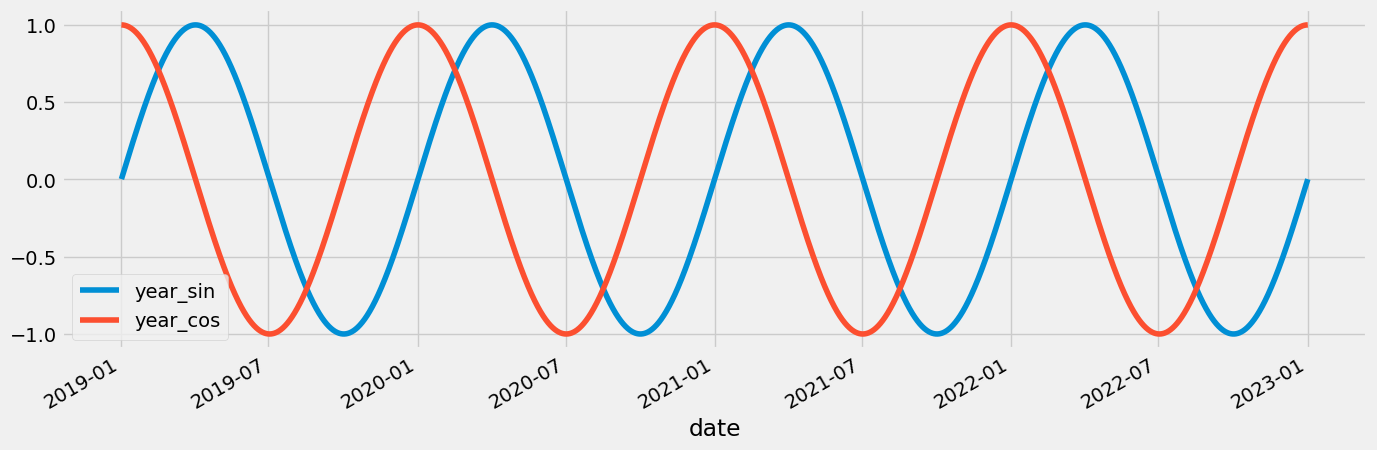

In [8]:
df[["year_sin", "year_cos"]].plot(figsize=(15, 5))
plt.show()

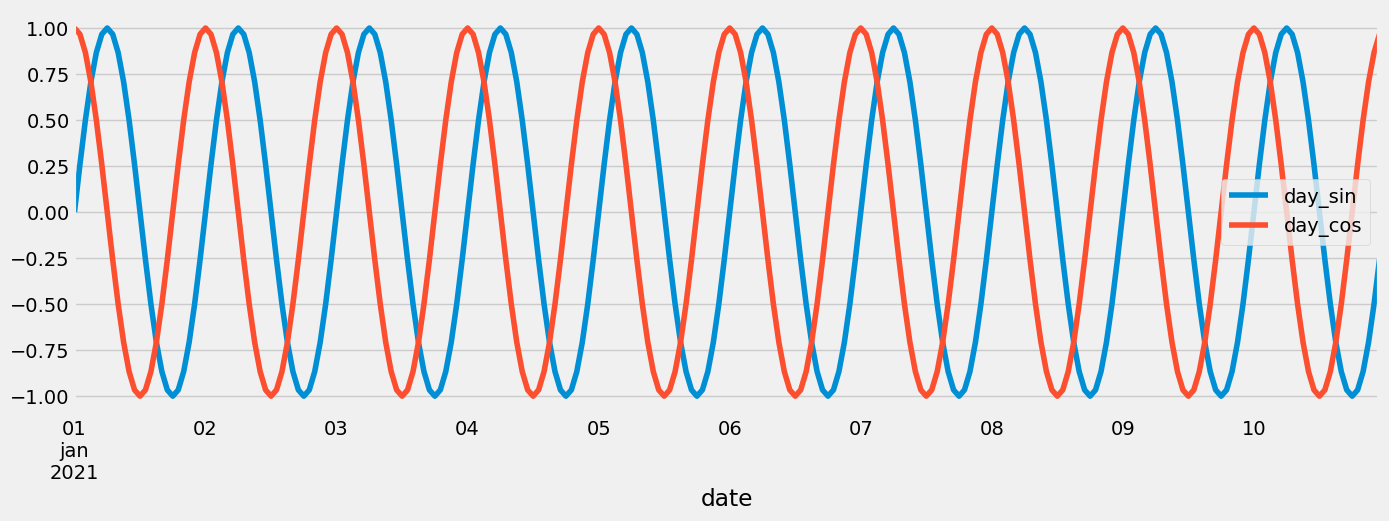

In [9]:
df[["day_sin", "day_cos"]]["20210101":"20210110"].plot(figsize=(15, 5))
plt.show()

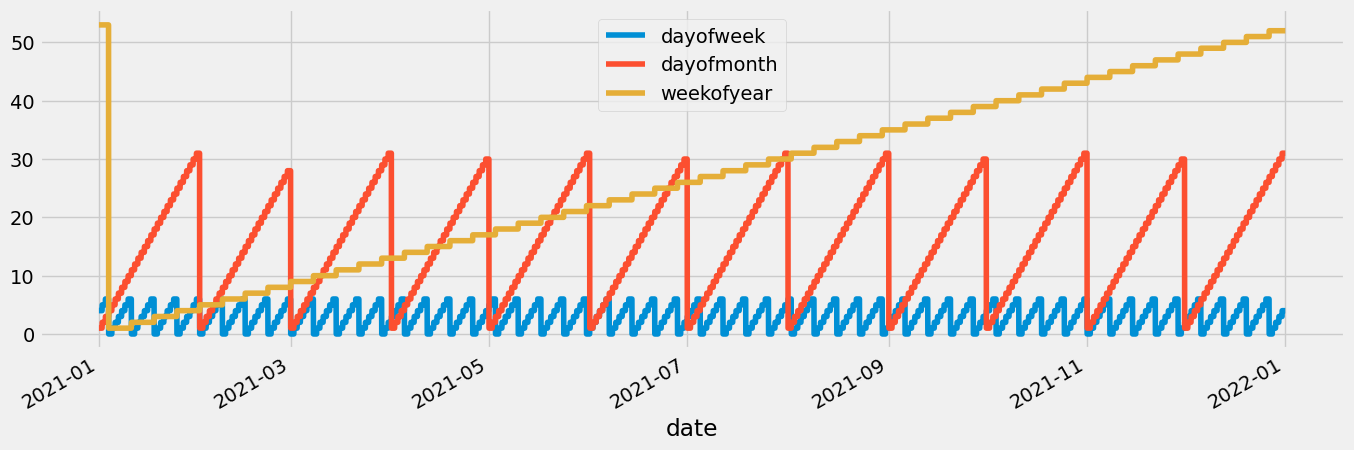

In [10]:
df[["dayofweek", "dayofmonth", "weekofyear"]]["20210101":"20211231"].plot(
    figsize=(15, 5)
)
plt.show()

## *Features* sur la température

### Différence des températures

Nous savons que les degrés-jour sont une méthode pour calculer les besoins de chauffage et de climatisation dans le bâtiment. 

Nous voyons souvent dans la documentation des HDD (Heating Degree Days) en base 18C, c'est-à-dire qu'aucun chauffage n'est requis en haut de 18 et que plus on s'éloigne de cette température, plus le chauffage sera requis.

La même chose s'applique en CDD (Cooling Degree Days), mais en base 21C. 

D'autres sources utilisent 24 et 16. Calculons plusieurs écarts à ces températures de même que des intervalles centrés sur 18 et 21C. 

Ref :
- https://www.iea.org/data-and-statistics/charts/cooling-degree-days-in-canada-2000-2020
- https://www.iea.org/data-and-statistics/charts/heating-degree-days-in-canada-2000-2020


In [11]:
def create_deltaTemp_features(df):
    """
    Création des features concernant les dates
    """
    df = df.copy()

    base_CDD_21 = 21
    base_CDD_24 = 24
    base_HDD_18 = 18
    base_HDD_16 = 16

    df["CDD_21"] = df.Temp.apply(lambda t: 0 if t <= base_CDD_21 else t - base_CDD_21)
    df["HDD_18"] = df.Temp.apply(lambda t: 0 if t >= base_HDD_18 else base_HDD_18 - t)
    df["CDD_24"] = df.Temp.apply(lambda t: 0 if t <= base_CDD_24 else t - base_CDD_24)
    df["HDD_16"] = df.Temp.apply(lambda t: 0 if t >= base_HDD_16 else base_HDD_16 - t)

    df["DT_18-21"] = df["HDD_18"] + df["CDD_21"]
    df["DT_16-24"] = df["HDD_16"] + df["CDD_24"]

    df["DT_18"] = abs(df["Temp"] - base_HDD_18)
    df["DT_21"] = abs(df["Temp"] - base_CDD_21)

    return df


df = create_deltaTemp_features(df)
df

,MW,Temp,hourofday,dayofweek,quarter,year,dayofyear,dayofmonth,weekofyear,season,...,year_sin,year_cos,CDD_21,HDD_18,CDD_24,HDD_16,DT_18-21,DT_16-24,DT_18,DT_21
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,0.0,0,1,1,2019,1,1,1,Hiver,...,0.002021,0.999998,0.0,18.0,0.0,16.0,18.0,16.0,18.0,21.0
2019-01-01 01:00:00,23762.55,0.0,1,1,1,2019,1,1,1,Hiver,...,0.002738,0.999996,0.0,18.0,0.0,16.0,18.0,16.0,18.0,21.0
2019-01-01 02:00:00,23830.23,-0.2,2,1,1,2019,1,1,1,Hiver,...,0.003455,0.999994,0.0,18.2,0.0,16.2,18.2,16.2,18.2,21.2
2019-01-01 03:00:00,23608.07,-0.5,3,1,1,2019,1,1,1,Hiver,...,0.004172,0.999991,0.0,18.5,0.0,16.5,18.5,16.5,18.5,21.5
2019-01-01 04:00:00,23562.48,-1.0,4,1,1,2019,1,1,1,Hiver,...,0.004888,0.999988,0.0,19.0,0.0,17.0,19.0,17.0,19.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,23381.99,1.9,19,5,4,2022,365,31,52,Hiver,...,-0.001047,0.999999,0.0,16.1,0.0,14.1,16.1,14.1,16.1,19.1
2022-12-31 20:00:00,22627.35,2.5,20,5,4,2022,365,31,52,Hiver,...,-0.000330,1.000000,0.0,15.5,0.0,13.5,15.5,13.5,15.5,18.5
2022-12-31 21:00:00,22004.14,2.1,21,5,4,2022,365,31,52,Hiver,...,0.000387,1.000000,0.0,15.9,0.0,13.9,15.9,13.9,15.9,18.9


## Visualisation des **delta température**

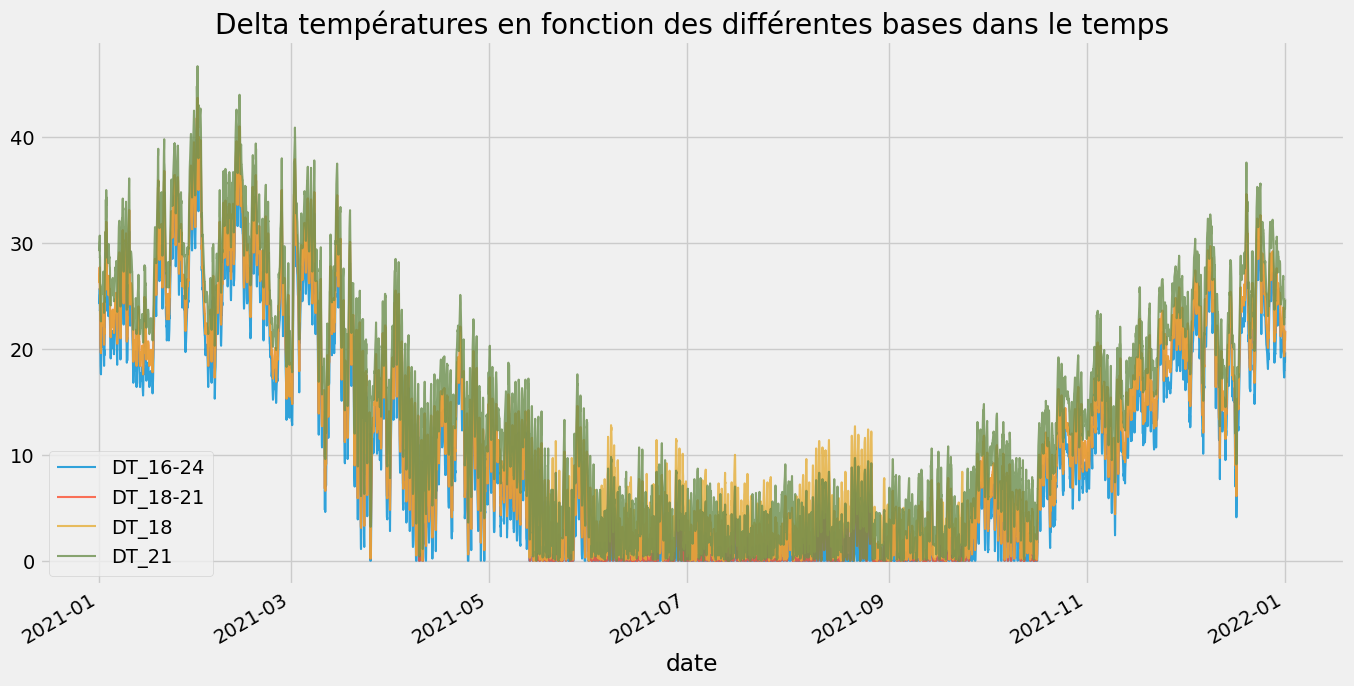

In [25]:
df[["DT_16-24", "DT_18-21", "DT_18", "DT_21"]]["20210101":"20211231"].plot(
    figsize=(15, 8),
    linewidth=1.5,
    alpha=0.8,
    title="Delta températures en fonction des différentes bases dans le temps",
)
plt.show()